# Simulation result analysis for RRT*

In [29]:
from matplotlib import tri
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.gridspec import GridSpec


def plotf_vector(xplot, yplot, values, title=None, alpha=None, cmap=get_cmap("BrBG", 10),
                 cbar_title='test', colorbar=True, vmin=None, vmax=None, ticks=None,
                 xlabel=None, ylabel=None):
    """ Note for triangulation:
    - Maybe sometimes it cannot triangulate based on one axis, but changing to another axis might work.
    - So then the final output needs to be carefully treated so that it has the correct visualisation.
    - Also note, the floating point number can cause issues as well.
    """
    """ To show threshold as a red line, then vmin, vmax, stepsize, threshold needs to have values. """
    triangulated = tri.Triangulation(xplot, yplot)
    x_triangulated = xplot[triangulated.triangles].mean(axis=1)
    y_triangulated = yplot[triangulated.triangles].mean(axis=1)

#     ind_mask = []
#     for i in range(len(x_triangulated)):
#         ind_mask.append(is_masked(values[i]))

    # triangulated.set_mask(ind_mask)
    refiner = tri.UniformTriRefiner(triangulated)
    triangulated_refined, value_refined = refiner.refine_field(values.flatten(), subdiv=3)

    """ extract new x and y, refined ones. """
    # xre_plot = triangulated_refined.x
    # yre_plot = triangulated_refined.y
    ax = plt.gca()
    # ax.triplot(triangulated, lw=0.5, color='white')
    contourplot = ax.tricontourf(triangulated_refined, value_refined, cmap=cmap, alpha=alpha)
    ax.tricontour(triangulated_refined, value_refined, vmin=vmin, vmax=vmax, alpha=alpha)
    # contourplot = ax.tricontourf(yre_plot, xre_plot, value_refined, cmap=cmap, alpha=alpha)
    # ax.tricontour(yre_plot, xre_plot, value_refined, vmin=vmin, vmax=vmax, alpha=alpha)

    if colorbar:
        cbar = plt.colorbar(contourplot, ax=ax, ticks=ticks)
        cbar.ax.set_title(cbar_title)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax, value_refined


['IVR_time.npy', 'EQUAL_cost.npy', 'EIBV_time.npy', 'EIBV_distance.npy', 'EQUAL_distance.npy', 'EIBV_cost.npy', 'IVR_distance.npy', 'IVR_cost.npy', 'EQUAL_time.npy']


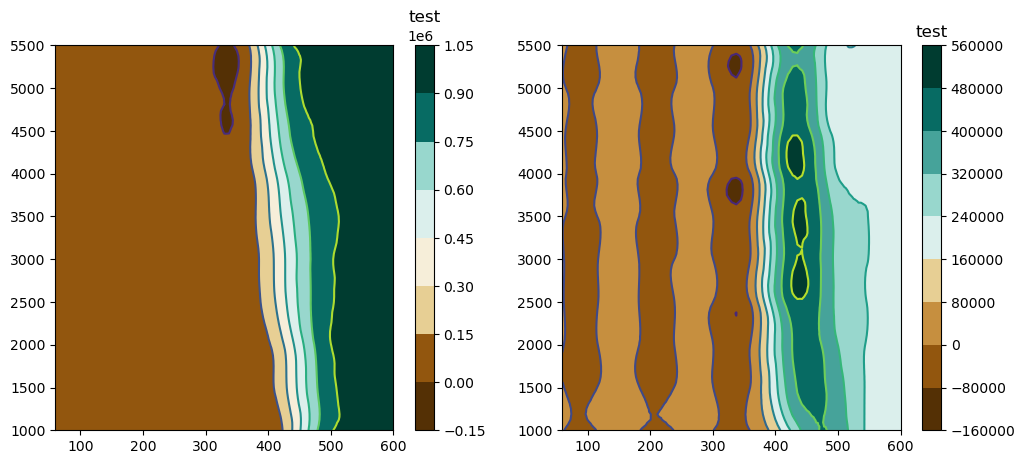

In [35]:

stepsizes = np.arange(60, 601, 60)
max_iterations = np.arange(1000, 6000, 500)

# case = "EQUAL"
case = "equal"
# case = "EIBV"
# metric = "time"
metric = "distance"
# metric = "cost"


filepath = "npy/RRT/"

print(os.listdir(filepath))

c = np.load(filepath + case.upper() + "_" + metric.lower() + ".npy")
# c[c==np.inf] = 999999
sd = np.std(c, axis=0)

dc = []
for i in range(len(stepsizes)): 
    for j in range(len(max_iterations)): 
        dc.append([stepsizes[i], max_iterations[j], np.mean(c[:, i, j], axis=0), sd[i, j]])
dc = np.array(dc)

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(nrows=1, ncols=2)
ax = fig.add_subplot(gs[0])
plotf_vector(dc[:, 0], dc[:, 1], values=dc[:, 2])
# im = ax.scatter(dc[:, 0], dc[:, 1], c=dc[:, 2], cmap=get_cmap("RdBu", 10), s=1500)
# plt.colorbar(im)
# ax.set_xlabel("Stepsize")
# ax.set_ylabel("Max expansion iterations")
# ax.set_title(metric)

ax = fig.add_subplot(gs[1])
plotf_vector(dc[:, 0], dc[:, 1], values=dc[:, 3])
# im = ax.scatter(dc[:, 0], dc[:, 1], c=dc[:, 3], cmap=get_cmap("RdBu", 10), s=1500)
# plt.colorbar(im)
# ax.set_xlabel("Stepsize")
# ax.set_ylabel("Max expansion iterations")
# ax.set_title("STD")

plt.show()


In [ ]:

# xplot = ddc[:, 0]
# yplot = ddc[:, 1]
# zplot = ddc[:, 2]

# xplot = stepsizes
# yplot = max_iterations
# zplot = np.mean(c, axis=0)
# sd = np.std(c, axis=0)
# N = c.shape[0]
def plot_figure(value=None, vmin=0, vmax=30, filename=None, title=None, cmap=None):
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scene'}]])
    """Surface""" 
    fig.add_trace(go.Surface(
        x=xplot,
        y=yplot,
        z=zplot,
    ))
    
    """Surface""" 
    fig.add_trace(go.Surface(
        x=xplot,
        y=yplot,
        z=zplot + sd,
    ))
    
    """Surface""" 
    fig.add_trace(go.Surface(
        x=xplot,
        y=yplot,
        z=zplot - sd,
    ))


    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1.5, y=2., z=1.7)  
    )
    fig.update_layout(
        title={
#             'text': "Conditional " + title + " field",
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        scene=dict(
            zaxis=dict(nticks=5, range=[0, 100], ),
            xaxis_tickfont=dict(size=14, family="Times New Roman"),
            yaxis_tickfont=dict(size=14, family="Times New Roman"),
            zaxis_tickfont=dict(size=14, family="Times New Roman"),
            xaxis_title=dict(text="Step sizes", font=dict(size=18, family="Times New Roman")),
            yaxis_title=dict(text="Max expansion iterations", font=dict(size=18, family="Times New Roman")),
            zaxis_title=dict(text="Cost", font=dict(size=18, family="Times New Roman")),
        ),
        scene_aspectmode='manual',
        scene_aspectratio=dict(x=1, y=1, z=1.5),
        scene_camera=camera,
    )
#     fig.write_image(filename, format='png', width=1980, height=1080)
    fig.show()

plot_figure()



In [17]:
v = np.inf
if v == np.inf: 
    print("h")
else: 
    print('f')
        

h


In [37]:
c = np.load(filepath + case.upper() + "_" + metric.lower() + ".npy")

In [50]:
for i in range(c.shape[0]):
    print("===========")
    print(c[i, :, :])


[[  973.22601984  2254.28630586  3802.3283004   5129.89733254
   6363.59077318  7350.86035892  8334.72991458  9710.19530245
  10711.56228835 11837.49993884]
 [12852.45376855 13884.56716718 15220.67082067 16681.71457668
  17835.64174052 18826.70183917 20314.09560136 21510.99817128
  22682.51690762 23858.18662406]
 [25270.89124482 26278.23141601 27655.13539367 29004.94816009
  29976.41540648 30957.90843564 32541.37568233 33601.45598933
  34850.98314293 35906.34865187]
 [36938.01700562 37909.02398936 38905.21798984 39956.22895191
  40937.82207867 41977.04121698 43595.73812572 44624.1097921
  45691.89079608 46694.11444476]
 [48154.31139026 49155.60378454 50137.1969113  51113.76401991
  52156.86994197 53152.83384763 54144.99598125 55116.81149955
  56256.95562728 57243.03016161]
 [58389.35615873 59371.21658828 60824.31114034 61799.82632074
  62771.27120629 63758.25382118 64908.74054537 65880.20779176
  67447.44409161 68443.76145138]
 [69716.81848648 70816.04053435 71837.73533753 74398.090903